# Import and load data

In [1]:
import re
import numpy as np
import pandas as pd
import copy

from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, EsmConfig, AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import os

In [2]:
combined = pd.read_csv('esm_dataset.csv')

In [3]:
combined.head()

,sequence,label
0,EVQLVESGGGLIQPGGSLRLSCAASGFIVSRNYMNWVRQAPGKGLE...,1
1,QVQMVESGGGLVRPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...,1
2,QVQLVESGGGVVQPGRSLRLSCASSGFTFSTYHMHWVRQPPGKGLE...,1
3,EVQLVESGGGLIQPGGSLRLSCAVSGFTVSRMSWVRQAPGKGLECV...,1
4,EVQLVESGGGLIQPGGSLRLSCAASEFIVSRNYMSWVRQAPGKGLE...,1


# ESM Fine Tuning Code

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and temporary sets (70% train, 30% temp)
train_set, temp_set = train_test_split(combined, test_size=0.3, random_state=950806, stratify=combined['label'])

# Further split the temporary set into validation and test sets (50% validation, 50% test)
valid_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=950806, stratify=temp_set['label'])


In [5]:
train_seqs = train_set['sequence'].tolist()
train_labels = train_set['label'].tolist()
valid_seqs = valid_set['sequence'].tolist()
valid_labels = valid_set['label'].tolist()
test_seqs = test_set['sequence'].tolist()
test_labels = test_set['label'].tolist()

In [6]:
model_name = "facebook/esm2_t6_8M_UR50D"  # Example model; replace with your specific model
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
train_tokenized = tokenizer(train_seqs)
test_tokenized = tokenizer(test_seqs)
valid_tokenized = tokenizer(valid_seqs)

In [11]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)
valid_dataset = Dataset.from_dict(valid_tokenized)
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 18727
})

In [12]:
train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)
valid_dataset = valid_dataset.add_column("labels", valid_labels)

train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 18727
})

In [13]:
valid_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4013
})

In [11]:
# config = EsmConfig.from_pretrained(model_name, {hidden_dropout_prob: 0.2})

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
config = model.config
config.hidden_dropout_prob = 0.1
print(config)

EsmConfig {
  "_name_or_path": "facebook/esm2_t6_8M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.32.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}



In [17]:
training_args = TrainingArguments(
    "ESM2-finetuned-localization",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/home/raylab/anaconda3/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [15]:
# training_args

In [14]:
from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Using the latest cached version of the module from /home/raylab/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Sun Mar  3 00:33:47 2024) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


In [16]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

NameError: name 'training_args' is not defined

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.470800,0.437229,0.806878
2,0.473900,0.431536,0.841266
3,0.427100,0.418806,0.856217
4,0.370200,0.431102,0.860703
5,0.344500,0.498974,0.874159
6,0.272000,0.551612,0.873411
7,0.213600,0.646663,0.873411
8,0.173800,0.634843,0.885622
9,0.083100,0.700271,0.890356
10,0.047900,0.798766,0.889609


TrainOutput(global_step=46820, training_loss=0.2938608292991511, metrics={'train_runtime': 700.8107, 'train_samples_per_second': 267.219, 'train_steps_per_second': 66.808, 'total_flos': 1080166545743448.0, 'train_loss': 0.2938608292991511, 'epoch': 10.0})

In [18]:
predictions = trainer.predict(test_dataset=test_dataset)


AttributeError: 'EsmForSequenceClassification' object has no attribute 'predict'

In [20]:
import numpy as np
from scipy.special import softmax

# Convert logits to probabilities
probabilities = softmax(predictions.predictions, axis=1)

# Determine the predicted class
predicted_classes = np.argmax(probabilities, axis=1)


In [21]:
probabilities

array([[9.9986160e-01, 1.3840169e-04],
       [2.3172576e-04, 9.9976832e-01],
       [4.0369455e-04, 9.9959630e-01],
       ...,
       [4.2463047e-04, 9.9957532e-01],
       [2.1080824e-03, 9.9789196e-01],
       [9.9914634e-01, 8.5368525e-04]], dtype=float32)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
f1 = f1_score(true_labels, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8769000747570396
Precision: 0.8542686242523111
Recall: 0.8742348358375069
F1 Score: 0.8641364136413641


In [23]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Compute ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_classes)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report (precision, recall, F1-score)
class_report = classification_report(true_labels, predicted_classes)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Print ROC AUC
print("\nROC AUC:", roc_auc)


Confusion Matrix:
[[1948  268]
 [ 226 1571]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2216
           1       0.85      0.87      0.86      1797

    accuracy                           0.88      4013
   macro avg       0.88      0.88      0.88      4013
weighted avg       0.88      0.88      0.88      4013


ROC AUC: 0.8766481038393312


In [15]:
bcr = pd.read_csv('BCR/airr_rearrangement.tsv', sep='\t')
heavy_chains = bcr.dropna(subset=['acdr3']).copy()
# heavy_chains = bcr['sequence_aa'].tolist()
heavy_chains.head()

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,is_cell,author_sequence_id,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup
1,karen_0_1,AAACGGGTCGAACGGA-1,clonotype4,GGACAGTTCTCTCTACAGTTACTGAGCACACAGGAACTCACCATGG...,MGWSYIILFLVATATGVHSQVQLQQSGAELVKPGASVKLSCKASGY...,T,F,IGHV1-53,42S351M269S,NaN,...,T,AAACGGGTCGAACGGA-1_contig_1,8,8,10,GYTFTSYY,INPSNGGT,TRNEGHYFDY,karen,home_interclone_interclone_work_Interclone_kar...
4,karen_0_4,AAACGGGTCGAACGGA-1,clonotype4,TGGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACT...,MGWSWIFLFLLSGTAGVHSEVQLQQSGPELVKPGASMKISCKASGY...,T,F,IGHV1-26,56S351M260S,NaN,...,T,AAACGGGTCGAACGGA-1_contig_4,8,8,7,GYSFTGYT,INPYNGGT,ASSSFDY,karen,home_interclone_interclone_work_Interclone_kar...
6,karen_0_6,AAAGCAAAGCCTCGTG-1,clonotype281,AACCTAAGATCAGTGGCCTCTCCACAGTCCCTGAACACACTGACTC...,MDWSWVFLFLLSVNEGVYCQVQLQQSGDDLVKPGASVKLSCKASGY...,T,F,IGHV1-77,51S351M281S,NaN,...,T,AAAGCAAAGCCTCGTG-1_contig_1,8,8,14,GYTFTSYW,IAPGSGST,ARGDGWGLRAWFAY,karen,home_interclone_interclone_work_Interclone_kar...
10,karen_0_10,AACACGTTCGACGGAA-1,clonotype220,TGGGGAGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGT...,MNFGLSLIFLVLILKGVQCEVQLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-6,85S353M273S,NaN,...,T,AACACGTTCGACGGAA-1_contig_2,8,8,12,GFTFSSYA,ISSGGSYT,ARIYGNHAWFAY,karen,home_interclone_interclone_work_Interclone_kar...
13,karen_0_13,AACCGCGAGCCCAGCT-1,clonotype278,TGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTG...,MGWSWIFLFLLSGTAGVHSEVQLQQSGPELVKPGASMKISCKASGY...,T,F,IGHV1-26,55S351M281S,NaN,...,T,AACCGCGAGCCCAGCT-1_contig_1,8,8,14,GYSFTGYT,INPYNGGT,ARGEYGNYFAWFAY,karen,home_interclone_interclone_work_Interclone_kar...


In [25]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# Create a list to store the predictions
predicted_labels = []
predicted_probabilities = []
# Iterate through each sequence in the DataFrame
for sequence in heavy_chains['sequence_aa']:
    # Tokenize the sequence using the tokenizer
    encoded_sequence = tokenizer.encode_plus(sequence, return_tensors="pt", max_length=256, truncation=True)
    
    # Move the input tensors to the appropriate device
    input_ids = encoded_sequence['input_ids'].to(device)
    attention_mask = encoded_sequence['attention_mask'].to(device)
    
    # Make predictions for the current sequence
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        
    # Softmax to get probabilities
    probability = torch.softmax(logits, dim=1).squeeze().tolist()[1]
    # Take the argmax to get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()
    
    # Append to lists
    predicted_labels.append(predicted_label)
    predicted_probabilities.append(probability)

# Add to df
heavy_chains['predicted_label'] = predicted_labels
heavy_chains['predicted_probability'] = predicted_probabilities

In [ ]:
# Sort the DataFrame based on the maximum predicted probability in each list
heavy_chains_sorted = heavy_chains.sort_values(by='predicted_probability', ascending=False)

# Reset the index after sorting
heavy_chains_sorted.reset_index(drop=True, inplace=True)
heavy_chains_sorted.head(60)

In [27]:
!pwd

/home/raylab/Zihao


In [28]:
candidates = heavy_chains[heavy_chains['predicted_probability'] >=0.4]

In [ ]:
candidates

In [35]:
model.save_pretrained("ESM_fintuned/87.h5")
tokenizer.save_pretrained("ESM_fintuned/87.h5")

('ESM_fintuned/87.h5/tokenizer_config.json',
 'ESM_fintuned/87.h5/special_tokens_map.json',
 'ESM_fintuned/87.h5/vocab.txt',
 'ESM_fintuned/87.h5/added_tokens.json')

In [30]:
candidates.to_csv('BCR/esm_candidates_low_threshold.csv')

# ProtTrans Fine Tuning Code

In [8]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [9]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=1):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [10]:
def PT5_classification_model(num_labels, half_precision):
    # Load PT5 and tokenizer
    # possible to load the half preciion model (thanks to @pawel-rezo for pointing that out)
    if not half_precision:
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
        tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    elif half_precision and torch.cuda.is_available() : 
        tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16).to(torch.device('cuda'))
    else:
          raise ValueError('Half precision can be run on GPU only.')
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Transformer Model\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Model_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [11]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [12]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=256, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        num_labels= 1,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs= 10,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed= True,  #if gpu is large enough disable deepspeed for training speedup
        mixed= False,     #enable mixed precision training
        gpu= 1 ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, half_precision=False)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = mixed,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        if num_labels>1:  # for classification
            metric = load("accuracy")
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
        else:  # for regression
            metric = load("spearmanr")
            predictions, labels = eval_pred

        return metric.compute(predictions=predictions, references=labels)
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history

In [13]:
pos = df1[['heavy_sequence', 'label']]
neg = neg[['heavy_sequence', 'label']]
combined = pd.concat([pos, neg])
combined.columns = ["sequence","label"]
# combined['label'] = combined['label'].astype(float)

In [14]:
len(combined)

26753

In [15]:
my_train, temp_data = train_test_split(combined, test_size=0.2, random_state=950806)

# Step 2: Split the temporary data into validation and testing sets (50% for validation, 50% for testing)
my_valid, my_test = train_test_split(temp_data, test_size=0.5, random_state=950806)

# Print the sizes of the resulting sets
print("Training set size:", len(my_train))
print("Validation set size:", len(my_valid))
print("Testing set size:", len(my_test))

Training set size: 21402
Validation set size: 2675
Testing set size: 2676


In [16]:
max_length = 0

# Iterate over each sequence in the 'heavy_sequence' column
for sequence in combined['sequence']:
    # Calculate the length of the current sequence
    sequence_length = len(sequence)
    # Update max_length if the current sequence is longer
    if sequence_length > max_length:
        max_length = sequence_length

# Print the longest length
print("Longest length of sequences:", max_length)

Longest length of sequences: 226


In [17]:
my_train.head()

,sequence,label
2713,QVQLQESGPGLVKPSGTLSLTCAVSGGSISSSNWWSWVRQPPGKGL...,1
780,NRFGAILGLRLKKPGSSVKVSCKASGGTFSNYAINWVRQAPGQGLE...,1
109378,QVQLKQSGPGRVQPSQSLSITCTVSGFSLTSNGVVHWVRQSPGKGL...,0
72176,EVQLVQSGAEVKKPGESLKISCKGSGYSFTSYWIGWVRQMPGKGLE...,0
13817,EVQLVESGGGLVQPGGSLRLSCAVSGFTFSSYAMSWVRQAPGKGLE...,0


In [ ]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=2, batch=4, accum=2, epochs=10, seed=950806)

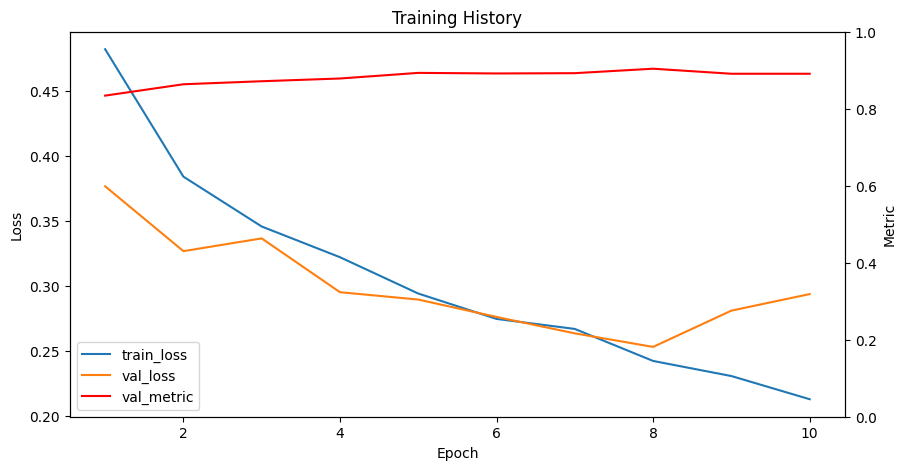

In [19]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

In [20]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=1, mixed = False):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, half_precision=mixed)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [21]:
save_model(model,"ProtTans/ESM2.pth")

In [22]:
len(list(my_valid['label']))

2675

In [23]:
print(my_test.head(5))
len(list(my_test['sequence'])[1])

                                                sequence  label
5058   TVTLDESGGGLQTPGGGLSLVCKASGFTFSSYCMQWVRQAPGKGLE...      1
3137   QVTLRESGPALVKPTQTLTLTCTFSGFSLSTSGMCVSWIRQPPGKA...      1
64942  QVQLQESGPGLVKPSETLSLTCAVSGYSISSGHYWTWIRQPPGKGL...      0
1361   QVQLVQSGTEVKKPGESLTISCKTSGYYFTTYWITWVRQMPGKGLE...      1
40568  GGVVQPGRSLSLSCAASGFTFNFYGMHWVRQAPGKGLEWVANVWYD...      0


126

In [24]:
# Preprocess sequences
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)

In [25]:
print(my_test.head(5))

                                                sequence  label
5058   T V T L D E S G G G L Q T P G G G L S L V C K ...      1
3137   Q V T L R E S G P A L V K P T Q T L T L T C T ...      1
64942  Q V Q L Q E S G P G L V K P S E T L S L T C A ...      0
1361   Q V Q L V Q S G T E V K K P G E S L T I S C K ...      1
40568  G G V V Q P G R S L S L S C A A S G F T F N F ...      0


In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set = create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████████████████████████████████████████████████████████| 168/168 [01:32<00:00,  1.82it/s]


In [27]:
# Regression
# print(stats.spearmanr(a=predictions, b=my_test.label, axis=0))

# Classification
# we need to determine the prediction class from the logit output
predictions= [item.argmax() for item in np.array(predictions)]
print("Accuracy: ", accuracy_score(my_test.label, predictions))

Accuracy:  0.8807922272047832


In [28]:
my_test

,sequence,label
5058,T V T L D E S G G G L Q T P G G G L S L V C K ...,1
3137,Q V T L R E S G P A L V K P T Q T L T L T C T ...,1
64942,Q V Q L Q E S G P G L V K P S E T L S L T C A ...,0
1361,Q V Q L V Q S G T E V K K P G E S L T I S C K ...,1
40568,G G V V Q P G R S L S L S C A A S G F T F N F ...,0
...,...,...
120812,Q V Q L V Q S G A E V K K P G A S V K V S C K ...,0
2914,E V Q L Q Q S G A E L V R P G A S V K L S C T ...,1
122633,E V Q L L E S G G A L L Q P G G S L R L S C A ...,0
4330,Q V Q L V Q S G A E V K K P G A S V K V S C K ...,1


In [29]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Convert predictions and ground truth labels to numpy arrays
predicted_labels = np.array(predictions)
true_labels = np.array(my_test['label'])

# Compute ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report (precision, recall, F1-score)
class_report = classification_report(true_labels, predicted_labels)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Print ROC AUC
print("\nROC AUC:", roc_auc)


Confusion Matrix:
[[1256  233]
 [  86 1101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1489
           1       0.83      0.93      0.87      1187

    accuracy                           0.88      2676
   macro avg       0.88      0.89      0.88      2676
weighted avg       0.89      0.88      0.88      2676


ROC AUC: 0.8855337909058453


In [30]:
bcr = pd.read_csv('BCR/airr_rearrangement.tsv', sep='\t')
bcr.shape

(729, 41)

In [31]:
heavy_chains = bcr.dropna(subset=['acdr3']).copy()
heavy_chains.shape
heavy_chains["sequence_aa"]=heavy_chains["sequence_aa"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
heavy_chains['sequence_aa']=heavy_chains.apply(lambda row : " ".join(row["sequence_aa"]), axis = 1)
heavy_chains.shape

(310, 41)

In [32]:
# Create a list to store the predictions
predicted_labels = []

# Iterate through each sequence in the DataFrame
for sequence in heavy_chains['sequence_aa']:
    # Tokenize the sequence using the tokenizer
    encoded_sequence = tokenizer.encode_plus(sequence, return_tensors="pt", max_length=256, truncation=True)
    
    # Move the input tensors to the appropriate device
    input_ids = encoded_sequence['input_ids'].to(device)
    attention_mask = encoded_sequence['attention_mask'].to(device)
    
    # Make predictions for the current sequence
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
    
    # Take the argmax to get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()
    
    # Append the predicted label to the list of predictions
    predicted_labels.append(predicted_label)

# Add the list of predictions as a new column in the DataFrame
heavy_chains['predicted_label'] = predicted_labels

In [33]:
candidates = heavy_chains[heavy_chains['predicted_label'] == 1].copy()
candidates.head()

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,author_sequence_id,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label
71,karen_0_71,ACGGAGAGTCAGGACA-1,clonotype114,ATCTGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGT...,M A V L G L L F C L V T F P S C V L S Q V Q L ...,T,F,IGHV2-2,38S350M264S,NaN,...,ACGGAGAGTCAGGACA-1_contig_2,8,7,9,GFSLTSYG,IWSGGST,ARNHYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1
76,karen_0_76,ACTATCTCAAGCTGTT-1,clonotype254,CCTTTTCTTAGCTGGGGATCTCCTCACTAGAGCCCCCATCAGAGCA...,M A V L V L F L C L V A F P S C V L S Q V Q L ...,T,F,IGHV2-9,45S350M279S,IGHD2-4,...,ACTATCTCAAGCTGTT-1_contig_2,8,7,14,GFSLTSYG,IWAGGST,ARVLSTMITTWFAY,karen,home_interclone_interclone_work_Interclone_kar...,1
80,karen_0_80,ACTTGTTAGTGTCTCA-1,clonotype183,TGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTT...,M A V L G L L F C L V T F P S C V L S Q V Q L ...,T,F,IGHV2-2,35S350M270S,NaN,...,ACTTGTTAGTGTCTCA-1_contig_2,8,7,11,GFSLTSYG,IWSGGST,ARGRVVTRGDY,karen,home_interclone_interclone_work_Interclone_kar...,1
90,karen_0_90,AGATCTGAGATATACG-1,clonotype275,GGGGATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGT...,M A V L V L F L C L V A F P S C V L S Q V Q L ...,T,F,IGHV2-9,32S350M282S,NaN,...,AGATCTGAGATATACG-1_contig_3,8,7,15,GFSLTSYG,IWAGGST,ARDITTVVDYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1
131,karen_0_131,AGTGGGAGTCACAAGG-1,clonotype169,GGGGGAAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGC...,M G W S C I I F F L V A T A T G V H S Q V Q L ...,T,F,IGHV1-64,52S351M269S,NaN,...,AGTGGGAGTCACAAGG-1_contig_1,8,8,10,GYTFTDYA,ISTYNGNT,AYGNYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,1
172,karen_0_172,ATCTGCCTCCAAACTG-1,clonotype214,ATCTGCCTCCAAACTGTGGCTCTACCTTTCTTATGGGGGGACAGTC...,M G W S C I I I F L V A T A T G V H S Q V Q L ...,T,F,IGHV1-52,69S351M272S,NaN,...,ATCTGCCTCCAAACTG-1_contig_1,8,8,11,SYTFTDYA,ISTYYGNT,ARGDGNYDFAY,karen,home_interclone_interclone_work_Interclone_kar...,1
184,karen_0_184,ATTTCTGGTGTGCCTG-1,clonotype129,TGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTT...,M A V L G L L F C L V T F P S C V L S Q V Q L ...,T,F,IGHV2-2,35S350M273S,NaN,...,ATTTCTGGTGTGCCTG-1_contig_2,8,7,12,GFSLTSYG,IWSGGST,ARGGYYGYYFDY,karen,home_interclone_interclone_work_Interclone_kar...,1
202,karen_0_202,CACACAACACTTCGAA-1,clonotype282,TGGGGATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGG...,M A V L V L F L C L V A F P S C V L S Q V Q L ...,T,F,IGHV2-9,33S350M282S,NaN,...,CACACAACACTTCGAA-1_contig_2,8,7,15,GFSLTSYG,IWAGGST,ARGSLLWYSYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,1
204,karen_0_204,CACACAATCTTGTACT-1,clonotype182,GAGATTCTCATTCAGTGATCAACACTGAACACACATCCCTTACCAT...,M D F G L I F F I V A L L K G V Q C E V K L L ...,T,F,IGHV4-1,44S350M270S,IGHD3-2,...,CACACAATCTTGTACT-1_contig_2,8,8,11,GFDFSRYW,INPGSSTI,ARLDSSGYFDY,karen,home_interclone_interclone_work_Interclone_kar...,1
236,karen_0_236,CATTCGCTCGTCCAGG-1,clonotype140,TGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTT...,M A V L G L L F C L V T F P S C V L S Q V Q L ...,T,F,IGHV2-2,35S350M267S,NaN,...,CATTCGCTCGTCCAGG-1_contig_2,8,7,10,GFSLTSYG,IWSGGST,ARSLRLGMDY,karen,home_interclone_interclone_work_Interclone_kar...,1


In [34]:
import re
candidates['sequence_aa'] = candidates['sequence_aa'].apply(lambda x: re.sub(r'\s+', '', x))

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,author_sequence_id,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label
71,karen_0_71,ACGGAGAGTCAGGACA-1,clonotype114,ATCTGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGT...,MAVLGLLFCLVTFPSCVLSQVQLKQSGPGLVQPSQSLSITCTVSGF...,T,F,IGHV2-2,38S350M264S,NaN,...,ACGGAGAGTCAGGACA-1_contig_2,8,7,9,GFSLTSYG,IWSGGST,ARNHYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1
76,karen_0_76,ACTATCTCAAGCTGTT-1,clonotype254,CCTTTTCTTAGCTGGGGATCTCCTCACTAGAGCCCCCATCAGAGCA...,MAVLVLFLCLVAFPSCVLSQVQLKESGPGLVAPSQSLSITCTVSGF...,T,F,IGHV2-9,45S350M279S,IGHD2-4,...,ACTATCTCAAGCTGTT-1_contig_2,8,7,14,GFSLTSYG,IWAGGST,ARVLSTMITTWFAY,karen,home_interclone_interclone_work_Interclone_kar...,1
80,karen_0_80,ACTTGTTAGTGTCTCA-1,clonotype183,TGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTT...,MAVLGLLFCLVTFPSCVLSQVQLKQSGPGLVQPSQSLSITCTVSGF...,T,F,IGHV2-2,35S350M270S,NaN,...,ACTTGTTAGTGTCTCA-1_contig_2,8,7,11,GFSLTSYG,IWSGGST,ARGRVVTRGDY,karen,home_interclone_interclone_work_Interclone_kar...,1
90,karen_0_90,AGATCTGAGATATACG-1,clonotype275,GGGGATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGT...,MAVLVLFLCLVAFPSCVLSQVQLKESGPGLVAPSQSLSITCTVSGF...,T,F,IGHV2-9,32S350M282S,NaN,...,AGATCTGAGATATACG-1_contig_3,8,7,15,GFSLTSYG,IWAGGST,ARDITTVVDYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1
131,karen_0_131,AGTGGGAGTCACAAGG-1,clonotype169,GGGGGAAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGC...,MGWSCIIFFLVATATGVHSQVQLQQSGPEVVRPGVSVKISCKGSGY...,T,F,IGHV1-64,52S351M269S,NaN,...,AGTGGGAGTCACAAGG-1_contig_1,8,8,10,GYTFTDYA,ISTYNGNT,AYGNYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,1
172,karen_0_172,ATCTGCCTCCAAACTG-1,clonotype214,ATCTGCCTCCAAACTGTGGCTCTACCTTTCTTATGGGGGGACAGTC...,MGWSCIIIFLVATATGVHSQVQLQQSGPELVRPGVSVKISCKGSSY...,T,F,IGHV1-52,69S351M272S,NaN,...,ATCTGCCTCCAAACTG-1_contig_1,8,8,11,SYTFTDYA,ISTYYGNT,ARGDGNYDFAY,karen,home_interclone_interclone_work_Interclone_kar...,1
184,karen_0_184,ATTTCTGGTGTGCCTG-1,clonotype129,TGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTT...,MAVLGLLFCLVTFPSCVLSQVQLKQSGPGLVQPSQSLSITCTVSGF...,T,F,IGHV2-2,35S350M273S,NaN,...,ATTTCTGGTGTGCCTG-1_contig_2,8,7,12,GFSLTSYG,IWSGGST,ARGGYYGYYFDY,karen,home_interclone_interclone_work_Interclone_kar...,1
202,karen_0_202,CACACAACACTTCGAA-1,clonotype282,TGGGGATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGG...,MAVLVLFLCLVAFPSCVLSQVQLKESGPGLVAPSQSLSITCTVSGF...,T,F,IGHV2-9,33S350M282S,NaN,...,CACACAACACTTCGAA-1_contig_2,8,7,15,GFSLTSYG,IWAGGST,ARGSLLWYSYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,1
204,karen_0_204,CACACAATCTTGTACT-1,clonotype182,GAGATTCTCATTCAGTGATCAACACTGAACACACATCCCTTACCAT...,MDFGLIFFIVALLKGVQCEVKLLESGGGLVQPGGSLNLSCAASGFD...,T,F,IGHV4-1,44S350M270S,IGHD3-2,...,CACACAATCTTGTACT-1_contig_2,8,8,11,GFDFSRYW,INPGSSTI,ARLDSSGYFDY,karen,home_interclone_interclone_work_Interclone_kar...,1
236,karen_0_236,CATTCGCTCGTCCAGG-1,clonotype140,TGGGGATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTT...,MAVLGLLFCLVTFPSCVLSQVQLKQSGPGLVQPSQSLSITCTVSGF...,T,F,IGHV2-2,35S350M267S,NaN,...,CATTCGCTCGTCCAGG-1_contig_2,8,7,10,GFSLTSYG,IWSGGST,ARSLRLGMDY,karen,home_interclone_interclone_work_Interclone_kar...,1


In [35]:
# candidates.to_csv('BCR/candidates.csv')

# Load Model

In [7]:
model_name = 'ESM_fintuned/87.h5'
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
model.config.output_hidden_states

True

In [9]:
model.eval()
# Move model to the appropriate device (cuda if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05,

# BCR

In [5]:
bcr = pd.read_csv('BCR/airr_rearrangement.tsv', sep='\t')
heavy_chains = bcr.dropna(subset=['acdr3']).copy()
# heavy_chains = bcr['sequence_aa'].tolist()
heavy_chains.head()

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,is_cell,author_sequence_id,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup
1,karen_0_1,AAACGGGTCGAACGGA-1,clonotype4,GGACAGTTCTCTCTACAGTTACTGAGCACACAGGAACTCACCATGG...,MGWSYIILFLVATATGVHSQVQLQQSGAELVKPGASVKLSCKASGY...,T,F,IGHV1-53,42S351M269S,NaN,...,T,AAACGGGTCGAACGGA-1_contig_1,8,8,10,GYTFTSYY,INPSNGGT,TRNEGHYFDY,karen,home_interclone_interclone_work_Interclone_kar...
4,karen_0_4,AAACGGGTCGAACGGA-1,clonotype4,TGGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACT...,MGWSWIFLFLLSGTAGVHSEVQLQQSGPELVKPGASMKISCKASGY...,T,F,IGHV1-26,56S351M260S,NaN,...,T,AAACGGGTCGAACGGA-1_contig_4,8,8,7,GYSFTGYT,INPYNGGT,ASSSFDY,karen,home_interclone_interclone_work_Interclone_kar...
6,karen_0_6,AAAGCAAAGCCTCGTG-1,clonotype281,AACCTAAGATCAGTGGCCTCTCCACAGTCCCTGAACACACTGACTC...,MDWSWVFLFLLSVNEGVYCQVQLQQSGDDLVKPGASVKLSCKASGY...,T,F,IGHV1-77,51S351M281S,NaN,...,T,AAAGCAAAGCCTCGTG-1_contig_1,8,8,14,GYTFTSYW,IAPGSGST,ARGDGWGLRAWFAY,karen,home_interclone_interclone_work_Interclone_kar...
10,karen_0_10,AACACGTTCGACGGAA-1,clonotype220,TGGGGAGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGT...,MNFGLSLIFLVLILKGVQCEVQLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-6,85S353M273S,NaN,...,T,AACACGTTCGACGGAA-1_contig_2,8,8,12,GFTFSSYA,ISSGGSYT,ARIYGNHAWFAY,karen,home_interclone_interclone_work_Interclone_kar...
13,karen_0_13,AACCGCGAGCCCAGCT-1,clonotype278,TGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTG...,MGWSWIFLFLLSGTAGVHSEVQLQQSGPELVKPGASMKISCKASGY...,T,F,IGHV1-26,55S351M281S,NaN,...,T,AACCGCGAGCCCAGCT-1_contig_1,8,8,14,GYSFTGYT,INPYNGGT,ARGEYGNYFAWFAY,karen,home_interclone_interclone_work_Interclone_kar...


In [6]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# Create a list to store the predictions
predicted_labels = []
predicted_probabilities = []
# Iterate through each sequence in the DataFrame
for sequence in heavy_chains['sequence_aa']:
    # Tokenize the sequence using the tokenizer
    encoded_sequence = tokenizer.encode_plus(sequence, return_tensors="pt", max_length=256, truncation=True)
    
    # Move the input tensors to the appropriate device
    input_ids = encoded_sequence['input_ids'].to(device)
    attention_mask = encoded_sequence['attention_mask'].to(device)
    
    # Make predictions for the current sequence
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        
    # Softmax to get probabilities
    probability = torch.softmax(logits, dim=1).squeeze().tolist()[1]
    # Take the argmax to get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()
    
    # Append to lists
    predicted_labels.append(predicted_label)
    predicted_probabilities.append(probability)

# Add to df
heavy_chains['predicted_label'] = predicted_labels
heavy_chains['predicted_probability'] = predicted_probabilities

In [7]:
heavy_chains

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
1,karen_0_1,AAACGGGTCGAACGGA-1,clonotype4,GGACAGTTCTCTCTACAGTTACTGAGCACACAGGAACTCACCATGG...,MGWSYIILFLVATATGVHSQVQLQQSGAELVKPGASVKLSCKASGY...,T,F,IGHV1-53,42S351M269S,NaN,...,8,8,10,GYTFTSYY,INPSNGGT,TRNEGHYFDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.990055
4,karen_0_4,AAACGGGTCGAACGGA-1,clonotype4,TGGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACT...,MGWSWIFLFLLSGTAGVHSEVQLQQSGPELVKPGASMKISCKASGY...,T,F,IGHV1-26,56S351M260S,NaN,...,8,8,7,GYSFTGYT,INPYNGGT,ASSSFDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.003990
6,karen_0_6,AAAGCAAAGCCTCGTG-1,clonotype281,AACCTAAGATCAGTGGCCTCTCCACAGTCCCTGAACACACTGACTC...,MDWSWVFLFLLSVNEGVYCQVQLQQSGDDLVKPGASVKLSCKASGY...,T,F,IGHV1-77,51S351M281S,NaN,...,8,8,14,GYTFTSYW,IAPGSGST,ARGDGWGLRAWFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000349
10,karen_0_10,AACACGTTCGACGGAA-1,clonotype220,TGGGGAGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGT...,MNFGLSLIFLVLILKGVQCEVQLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-6,85S353M273S,NaN,...,8,8,12,GFTFSSYA,ISSGGSYT,ARIYGNHAWFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000411
13,karen_0_13,AACCGCGAGCCCAGCT-1,clonotype278,TGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTG...,MGWSWIFLFLLSGTAGVHSEVQLQQSGPELVKPGASMKISCKASGY...,T,F,IGHV1-26,55S351M281S,NaN,...,8,8,14,GYSFTGYT,INPYNGGT,ARGEYGNYFAWFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.027352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,karen_0_718,TTTACTGGTAGAAGGA-1,clonotype256,ATATTGGGACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGG...,MRVLILLWLFTAFPGILSDVQLQESGPGLVKPSQSLSLTCTVTGYS...,T,F,IGHV3-1,62S350M279S,NaN,...,9,7,14,GYSITSDYA,ISYSGST,ARDYYGSSYGYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.001313
720,karen_0_720,TTTACTGGTTCACGGC-1,clonotype280,TGGATTCCCAGGTCCTCACATTCAGTGATCAGCACTGAACACAGAC...,MDSRLNLVFLVLFLKGVQCDVQLVESGGGVVQPGGSRKLSCAASGF...,T,F,IGHV5-17,54S351M161S,IGHD2-4,...,8,8,14,GFTFSSFG,ISSGSSTI,AREYYDYDVGYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000327
724,karen_0_724,TTTGGTTCAGGTCCAC-1,clonotype36,TGGGATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGT...,MAVLVLFLCLVAFPSCVLSQVQLKESGPGLVAPSQSLSITCTVSGF...,T,F,IGHV2-9,32S350M279S,IGHD1-1,...,8,7,14,GFSLTSYG,IWAGGST,ARDYYGSSYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000468
726,karen_0_726,TTTGGTTGTTCGTTGA-1,clonotype248,GGGGATCATCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTG...,MAVLALLFCLVTFPSCILSQVQLKESGPGLVAPSQSLSITCTVSGF...,T,F,IGHV2-6-8,34S350M276S,NaN,...,8,7,13,GFSLTGYG,IWGDGST,ASYGSSPLYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000321


In [16]:
# Sort the DataFrame based on the maximum predicted probability in each list
heavy_chains_sorted = heavy_chains.sort_values(by='predicted_probability', ascending=True)

# Reset the index after sorting
heavy_chains_sorted.reset_index(drop=True, inplace=True)
heavy_chains_sorted.head(20)

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
0,karen_0_227,CATATTCTCGAATGCT-1,clonotype106,GGGAGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTCAC...,MNFGLSLIFLVLVLKGVQCEVMLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-9,78S353M261S,NaN,...,8,8,8,GFTFSSYA,ISSGGSYT,ARHPPGDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000142
1,karen_0_465,GCGGGTTTCTGTCTAT-1,clonotype14,AGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTCAGTGA...,MNFGLSLIFLVLVLKGVQCEVQLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-4,72S353M276S,NaN,...,8,8,13,GFTFSDYY,ISDGGSYT,ARGLYRYDASMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000142
2,karen_0_626,TCAGCTCTCCACGAAT-1,clonotype103,TGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTCAGTGA...,MNFGLSLIFLVLVLKGVQCEVQLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-4,72S353M258S,NaN,...,8,8,7,GFTFSDYY,ISDGGSYT,ARDQPDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000144
3,karen_0_523,GGTGTTATCACGCGGT-1,clonotype113,GAAGCAAAGGGGATCAGCCCGAGATTCTCATTCAGTGATCAACACT...,MDFGLIFFIVALLKGVQCEVKLLESGGGLVQPGGSLKLSCAASGFD...,T,F,IGHV4-1,64S350M264S,NaN,...,8,8,9,GFDFSRYW,INPDSSTI,ARRGNYFDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000146
4,karen_0_223,CAGCTGGAGGCAGGTT-1,clonotype122,TGGGGAGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGT...,MNFGLSLIFLVLVLKGVQCEVMLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-9,85S353M261S,NaN,...,8,8,8,GFTFSSYA,ISSGGSYT,ARQGATGY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000148
5,karen_0_455,GCGACCAGTCCTAGCG-1,clonotype90,TGGGGAGCTCTGACAGAGGAGGCAGGTCCTGGATTCGATTCCCAGT...,MNFVLSLIFLALILKGVQCEVQLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-6,85S353M255S,NaN,...,8,8,6,GFTFSSYA,ISSGGSYT,ARHRAY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000150
6,karen_0_595,TAGTGGTGTGTTGGGA-1,clonotype96,TGGGGAGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGT...,MNFGLSLIFLALILKGVQCEVQLVESGGDLVKPGGSLKLSCAASGF...,T,F,IGHV5-6,85S353M258S,IGHD4-1,...,8,8,7,GFTFSSYG,ISSGGSYT,ARLTGAY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000150
7,karen_0_107,AGCGTATCACTCAGGC-1,clonotype118,TGGATTCCCAGGTCCTCACATTCAGTGATCAGCACTGAACACAGAC...,MDSRLNLVFLVLILKGVQCDVQLVESGGGLVQPGGSRKLSCAASGF...,T,F,IGHV5-17,54S351M263S,NaN,...,8,8,8,GFTFSSFG,ISSGSSTI,ARNYGKDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000151
8,karen_0_581,TACCTTATCCTTCAAT-1,clonotype30,TCAGCACTGAACACGGACCCCTCACCATGAACTTCGGGCTCAGCTT...,MNFGLSLIFLVLVLKGVQCEVMLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-9,26S353M264S,NaN,...,8,8,9,GFTFSSYA,ISSGGSYT,ARWGITSPV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000155
9,karen_0_349,CTGCTGTTCTTTACAC-1,clonotype30,GAGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCT...,MNFGLSLIFLVLVLKGVQCEVMLVESGGGLVKPGGSLKLSCAASGF...,T,F,IGHV5-9,81S353M264S,NaN,...,8,8,9,GFTFSSYA,ISSGGSYT,ARWGITSPV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.000155


In [ ]:
cc = pd.read_csv('BCR/cluster70_candidates.csv')
cc

In [17]:
heavy_chains_sorted.to_csv('BCR/predictions.csv', index=False)

In [14]:
negative_candidates = heavy_chains_sorted[~heavy_chains_sorted['sequence_id'].isin(cc['sequence_id'])].head(30)
negative_candidates.to_csv('BCR/low_score_candidates.csv', index=False)

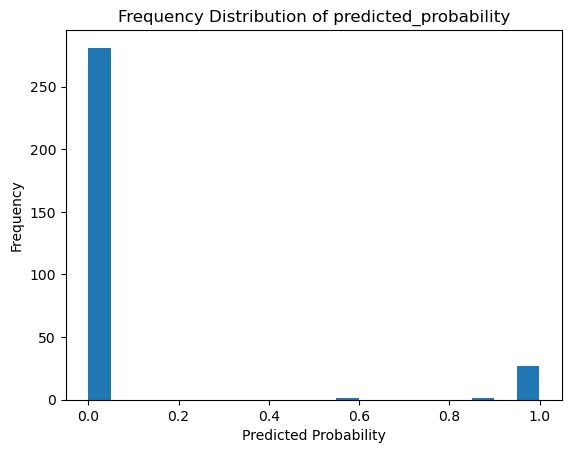

In [15]:
plt.hist(heavy_chains['predicted_probability'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of predicted_probability')
plt.show()


# Negative

In [11]:
negative = pd.read_csv('BCR/Negative/SC5v2_mousePBMCs_1Kcells_Connect_single_channel_SC5v2_mousePBMCs_1Kcells_Connect_single_channel_vdj_b_airr_rearrangement.tsv', sep='\t')
negative.head()

,cell_id,clone_id,sequence_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,v_sequence_end,d_sequence_start,d_sequence_end,j_sequence_start,j_sequence_end,c_sequence_start,c_sequence_end,consensus_count,duplicate_count,is_cell
0,AAACCTGAGCGTTTAC-1,clonotype41,AAACCTGAGCGTTTAC-1_contig_1,ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...,MMSPAQFLFLLVLWIRETNGDVVMTQTPLTLSVTIGQPASISCKSS...,T,F,IGKV1-135,32S362M118S,NaN,...,394,NaN,NaN,391,429,430.0,512.0,959,23,T
1,AAACCTGAGCGTTTAC-1,clonotype41,AAACCTGAGCGTTTAC-1_contig_2,GCTATGATCAATGTCTTCTTCACAGTCCCTGAACACACTGACTCTA...,MEWIWIFLFILSGTAGVQSQVQLQQSGAELARPGASVKLSCKASGY...,T,F,IGHV1-81,49S351M263S,NaN,...,400,NaN,NaN,415,452,453.0,663.0,745,10,T
2,AAACCTGAGCGTTTAC-1,clonotype41,AAACCTGAGCGTTTAC-1_contig_3,AGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTGCAGA...,MDFQVQIFSFLLISASVILSRGQIVLTQSPAIMSASPGEKVTMTCS...,T,F,IGKV4-55,27S352M116S,NaN,...,379,NaN,NaN,375,412,413.0,495.0,542,12,T
3,AAACCTGGTTTCCACC-1,clonotype243,AAACCTGGTTTCCACC-1_contig_1,ATGATCAGTGTCCTCTCTACACAGTCCCTGACGACACTGACTCTAA...,MGWSWIFLFLLSGTAGVHCQVQLQQSGPELVKPGASVKISCKASGY...,T,F,IGHV1-66,48S351M278S,IGHD2-5,...,399,404.0,420.0,419,466,467.0,677.0,1065,27,T
4,AAACCTGGTTTCCACC-1,clonotype243,AAACCTGGTTTCCACC-1_contig_2,TGGGGATTGTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCT...,MMSSAQFLGLLLLCFQGTRCDIQMTQTTSSLSASLGDRVTISCRAS...,T,F,IGKV10-96,36S347M118S,NaN,...,383,NaN,NaN,381,418,419.0,501.0,1417,26,T


In [12]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# Create a list to store the predictions
predicted_labels = []
predicted_probabilities = []
# Iterate through each sequence in the DataFrame
for sequence in negative['sequence_aa']:
    # Tokenize the sequence using the tokenizer
    encoded_sequence = tokenizer.encode_plus(sequence, return_tensors="pt", max_length=256, truncation=True)
    
    # Move the input tensors to the appropriate device
    input_ids = encoded_sequence['input_ids'].to(device)
    attention_mask = encoded_sequence['attention_mask'].to(device)
    
    # Make predictions for the current sequence
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        
    # Softmax to get probabilities
    probability = torch.softmax(logits, dim=1).squeeze().tolist()[1]
    # Take the argmax to get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()
    
    # Append to lists
    predicted_labels.append(predicted_label)
    predicted_probabilities.append(probability)

# Add to df
negative['predicted_label'] = predicted_labels
negative['predicted_probability'] = predicted_probabilities

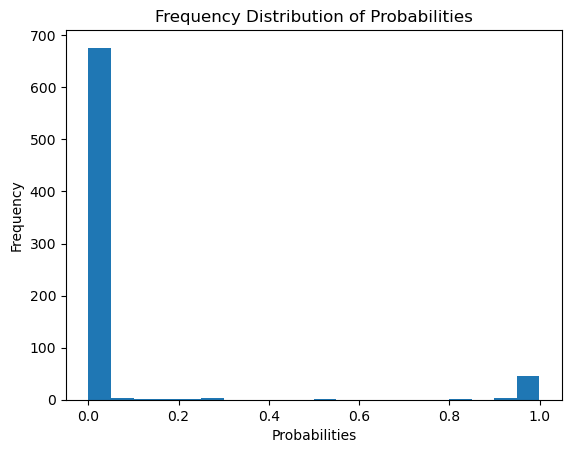

In [19]:
plt.hist(negative['predicted_probability'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Probabilities')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Probabilities')
plt.show()

In [17]:
negative_selected = negative[negative['predicted_probability'] >=0.9] # 51 '1's out of 738 input

In [18]:
negative_selected.to_csv('BCR/esm_negative_candidates.csv')

In [110]:
esm = pd.read_csv('BCR/esm_candidates_low_threshold.csv')

In [ ]:
esm

In [124]:
# Sort the DataFrame based on the maximum predicted probability in each list
heavy_chains_sorted = heavy_chains.sort_values(by='predicted_probability', ascending=False)

# Reset the index after sorting
heavy_chains_sorted.reset_index(drop=True, inplace=True)

In [120]:
heavy_chains_sorted.loc[len(heavy_chains_sorted)-60:, 'predicted_probability'] = esm.loc[:59, 'predicted_probability']

In [128]:
toplot = heavy_chains_sorted.loc[:60, 'predicted_probability'].tolist() + esm['predicted_probability'].tolist()

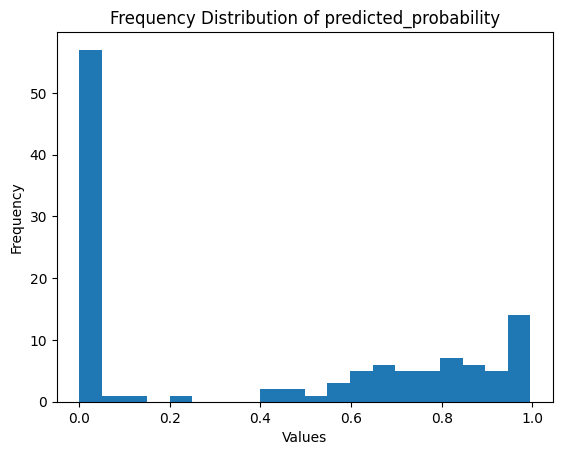

In [129]:
plt.hist(toplot, bins=20)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of predicted_probability')
plt.show()


In [117]:
heavy_chains_sorted

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
0,karen_0_29,AAGCCGCGTGGAAAGA-1,clonotype320,TGGGGGACATATGACCAATATCCTCTCCACATTCCCTTAAGACACT...,MGWIWIFLFLLSGTAGVHSEVQLQQSGPELVKTGASVKISCKASGY...,T,F,IGHV1-19,56S351M290S,NaN,...,8,8,17,GYSFTGYY,ISCYNGAT,ARGGIWYGSSRGDAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.831627
1,karen_0_517,GGTGAAGCAGGGCATA-1,clonotype316,GGGAACCTATGATCAGTATCCTCTCCACAGTCCCTGAACACACTGA...,MEWSWVFLFLLSLTSGVHSHVQLQQSGPELVRPGASVKLSCKASGY...,T,F,IGHV1-56,54S351M287S,NaN,...,8,8,16,GYIFITYW,IFPASGST,ARGGYYYGSHYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.230298
2,karen_0_393,GAATGAAAGGGCTTGA-1,clonotype274,GAACCTATGATCAGTATCCTCTCCACAGTCCCTGAACACACTGACT...,MEWSWVFLFLLSLTSGVHSHVQLQQSGPELVRPGASVKLSCKASGY...,T,F,IGHV1-56,52S351M281S,NaN,...,8,8,14,GYIFITYW,IFPASGST,ARANPLHYYGYFDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.134521
3,karen_0_637,TCGGGACCACCAGGCT-1,clonotype226,TGGGGAACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACT...,MGWSWIFLFLLSGTAGVLSEVQLQQSGPELVKPGASVKISCKTSGY...,T,F,IGHV1-22,56S351M275S,NaN,...,8,8,12,GYTFTEYT,INPNNGGT,AGTEAYYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.099683
4,karen_0_568,GTTCGGGAGGTGGGTT-1,clonotype204,GACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGCCATGG...,MGWSCIIFFLVATATGVHSQVQLQQSGPEVVRPGVSVKISCKGSGY...,T,F,IGHV1-64,42S351M272S,IGHD1-1,...,8,8,11,GYTFTDYA,ISTYNGNT,AVITTVVATDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.045497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,karen_0_623,TCAGCAAGTATAGTAG-1,clonotype102,TGGGGGACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAG...,MYLGLNCVFIVFLLKGVQSEVKLEESGGGLVQPGGSMKLSCVASGF...,T,F,IGHV6-6,74S357M254S,NaN,...,8,10,5,GFTFSNYW,IRLKSNNYAT,EGFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN
306,karen_0_124,AGTAGTCAGTTTCCTT-1,clonotype142,TGGGGAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCCTGCT...,MGRLTSSFLLLIVPAYVLSQVTLKESGPGILQPSQTLSLTCSFSGF...,T,F,IGHV8-8,17S358M259S,NaN,...,10,7,8,GFSLSTSGMG,IWWDDVK,ARNDGFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN
307,karen_0_275,CGAATGTAGAAACGAG-1,clonotype127,TGGGGAGCGTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCC...,MKLWLNWIFLVTLLNGIQCEVKLVESGGGLVQPGGSLRLSCATSGF...,T,F,IGHV7-3,84S361M256S,NaN,...,8,10,7,GFTFTDYY,IRNKANGYTT,ARGWFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN
308,karen_0_374,CTTCTCTAGTGTTAGA-1,clonotype136,TGGGGAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCCTGCT...,MGRLTSSFLLLIVPAYVLSQVTLKESGPGILQPSQTLSLTCSFSGF...,T,F,IGHV8-8,17S358M259S,NaN,...,10,7,8,GFSLSTSGMG,IWWDDVK,ARIPLFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN


In [107]:
heavy_chains_sorted

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
0,karen_0_29,AAGCCGCGTGGAAAGA-1,clonotype320,TGGGGGACATATGACCAATATCCTCTCCACATTCCCTTAAGACACT...,MGWIWIFLFLLSGTAGVHSEVQLQQSGPELVKTGASVKISCKASGY...,T,F,IGHV1-19,56S351M290S,NaN,...,8,8,17,GYSFTGYY,ISCYNGAT,ARGGIWYGSSRGDAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.831627
1,karen_0_517,GGTGAAGCAGGGCATA-1,clonotype316,GGGAACCTATGATCAGTATCCTCTCCACAGTCCCTGAACACACTGA...,MEWSWVFLFLLSLTSGVHSHVQLQQSGPELVRPGASVKLSCKASGY...,T,F,IGHV1-56,54S351M287S,NaN,...,8,8,16,GYIFITYW,IFPASGST,ARGGYYYGSHYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.230298
2,karen_0_393,GAATGAAAGGGCTTGA-1,clonotype274,GAACCTATGATCAGTATCCTCTCCACAGTCCCTGAACACACTGACT...,MEWSWVFLFLLSLTSGVHSHVQLQQSGPELVRPGASVKLSCKASGY...,T,F,IGHV1-56,52S351M281S,NaN,...,8,8,14,GYIFITYW,IFPASGST,ARANPLHYYGYFDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.134521
3,karen_0_637,TCGGGACCACCAGGCT-1,clonotype226,TGGGGAACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACT...,MGWSWIFLFLLSGTAGVLSEVQLQQSGPELVKPGASVKISCKTSGY...,T,F,IGHV1-22,56S351M275S,NaN,...,8,8,12,GYTFTEYT,INPNNGGT,AGTEAYYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.099683
4,karen_0_568,GTTCGGGAGGTGGGTT-1,clonotype204,GACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGCCATGG...,MGWSCIIFFLVATATGVHSQVQLQQSGPEVVRPGVSVKISCKGSGY...,T,F,IGHV1-64,42S351M272S,IGHD1-1,...,8,8,11,GYTFTDYA,ISTYNGNT,AVITTVVATDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.045497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,karen_0_623,TCAGCAAGTATAGTAG-1,clonotype102,TGGGGGACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAG...,MYLGLNCVFIVFLLKGVQSEVKLEESGGGLVQPGGSMKLSCVASGF...,T,F,IGHV6-6,74S357M254S,NaN,...,8,10,5,GFTFSNYW,IRLKSNNYAT,EGFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN
306,karen_0_124,AGTAGTCAGTTTCCTT-1,clonotype142,TGGGGAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCCTGCT...,MGRLTSSFLLLIVPAYVLSQVTLKESGPGILQPSQTLSLTCSFSGF...,T,F,IGHV8-8,17S358M259S,NaN,...,10,7,8,GFSLSTSGMG,IWWDDVK,ARNDGFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN
307,karen_0_275,CGAATGTAGAAACGAG-1,clonotype127,TGGGGAGCGTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCC...,MKLWLNWIFLVTLLNGIQCEVKLVESGGGLVQPGGSLRLSCATSGF...,T,F,IGHV7-3,84S361M256S,NaN,...,8,10,7,GFTFTDYY,IRNKANGYTT,ARGWFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN
308,karen_0_374,CTTCTCTAGTGTTAGA-1,clonotype136,TGGGGAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCCTGCT...,MGRLTSSFLLLIVPAYVLSQVTLKESGPGILQPSQTLSLTCSFSGF...,T,F,IGHV8-8,17S358M259S,NaN,...,10,7,8,GFSLSTSGMG,IWWDDVK,ARIPLFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,NaN


# Embeddings

In [5]:
def get_embeddings(sequences):
    inputs = tokenizer(sequences, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()  # Use mean of token embeddings as sequence embedding


In [16]:
embeddings = get_embeddings(test_seqs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 864.00 MiB. GPU 0 has a total capacity of 23.67 GiB of which 63.56 MiB is free. Process 62331 has 726.00 MiB memory in use. Process 103992 has 14.81 GiB memory in use. Process 211141 has 932.00 MiB memory in use. Process 222584 has 1014.00 MiB memory in use. Process 417080 has 360.00 MiB memory in use. Including non-PyTorch memory, this process has 5.43 GiB memory in use. Of the allocated memory 5.10 GiB is allocated by PyTorch, and 31.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)